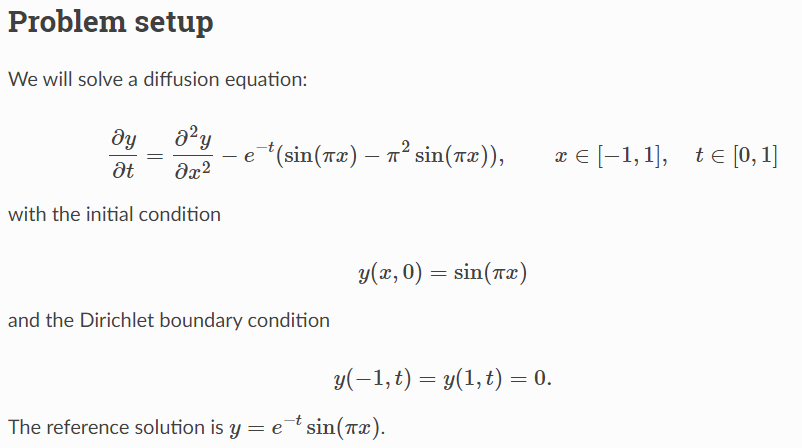

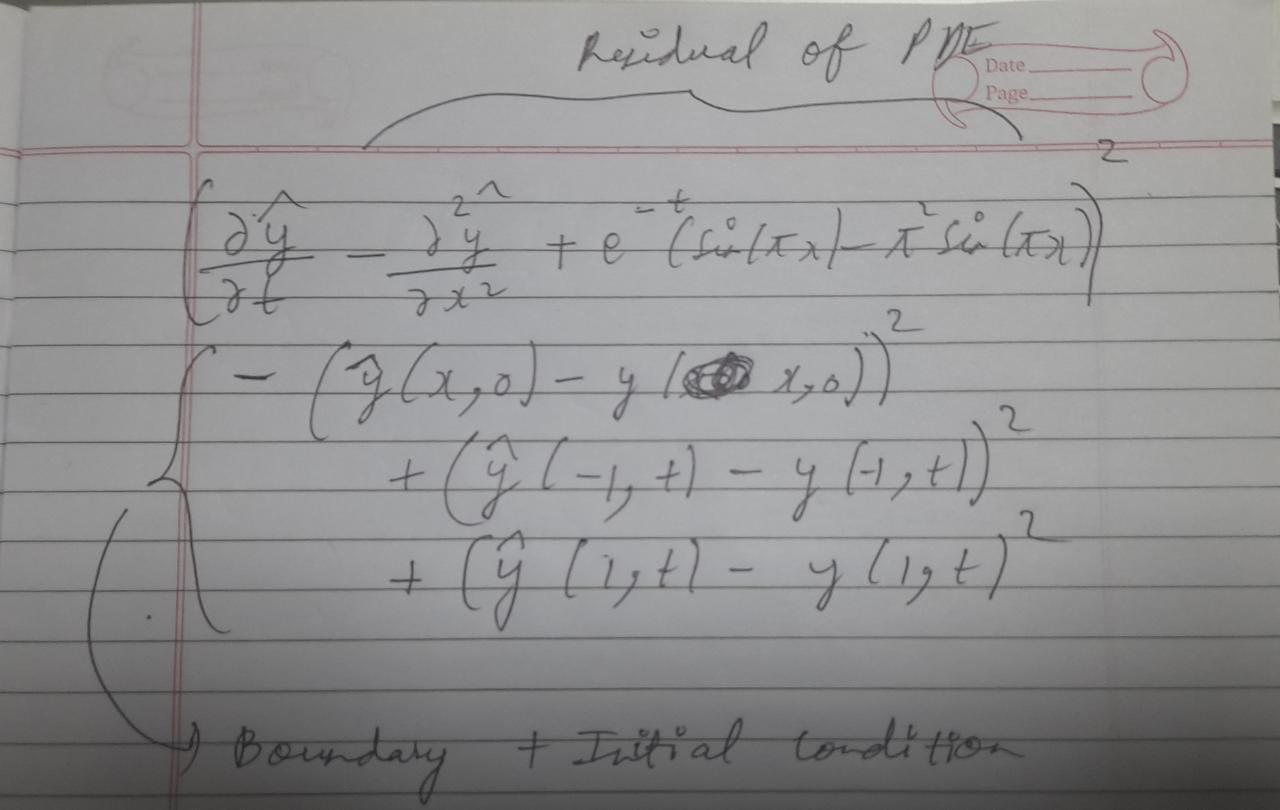

In [2]:
import torch
import torch.autograd as autograd         
from torch import Tensor                  
import torch.nn as nn                     
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         
import scipy.io

In [3]:
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [4]:
def function(x,t):
    return torch.exp(-t)*(torch.sin(np.pi*x))

In [5]:
def plot3D(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot)
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()
    
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

C:\Users\atuly\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


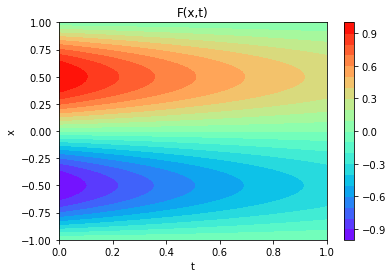

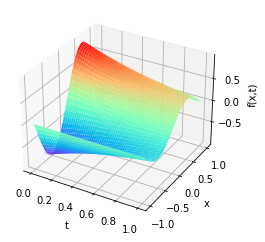

In [6]:
x=torch.linspace(-1,1,2000).view(-1,1)
t=torch.linspace(0,1,1000).view(-1,1)

X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))

y_real=function(X,T)
plot3D(x,t,y_real)

In [7]:
# Transform the mesh into a 2-column vector

x_test=torch.hstack((X.transpose(1,0).flatten().reshape(-1,1),T.transpose(1,0).flatten().reshape(-1,1)))
y_test=y_real.transpose(1,0).flatten().reshape(-1,1)

print(x_test.shape,y_test.shape)

torch.Size([2000000, 2]) torch.Size([2000000, 1])


In [8]:
#x(x,0)=sin(pix)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0].reshape(-1,1),T[:,0].reshape(-1,1))) # First column 
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

#x=min; tmin=<t=<max
top_X=torch.hstack((X[0,:].reshape(-1,1),T[0,:].reshape(-1,1))) # First row 
top_Y=torch.zeros(top_X.shape[0],1)

#x=max; 0=<t=<1
bottom_X=torch.hstack((X[-1,:].reshape(-1,1),T[-1,:].reshape(-1,1))) # Last row 
bottom_Y=torch.zeros(bottom_X.shape[0],1)

X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

#Choose points of our available training data:
idx=np.random.choice(X_train.shape[0],100,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

lb=x_test[0] 
ub=x_test[-1]

X_train_Nf = np.linspace(lb,ub,10000)
X_train_Nf = torch.from_numpy(X_train_Nf)

f_hat = torch.zeros(10000,1).to(device)

In [17]:
type(X_train_Nf)

torch.Tensor

In [9]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0 
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   
    
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    
    def lossBC(self,x_BC,y_BC):
            loss_BC=self.loss_function(self.forward(x_t_BC),y_BC)
            return loss_BC

    def lossPDE(self,x_PDE):
            g=x_PDE.clone()
            g.requires_grad=True 
            f=self.forward(g)
            f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
            f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0] #second derivative
            f_t=f_x_t[:,[1]]
            f_xx=f_xx_tt[:,[0]] 
            f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
            return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_pde):
            loss_bc=self.lossBC(x_BC,y_BC)
            loss_pde = self.lossPDE(x_pde)
            return loss_bc + loss_pde


In [10]:
X_train_Nu.shape

torch.Size([100, 2])

In [11]:
layers = np.array([2,32,32,1])

PINN = FCN(layers)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=1e-3,amsgrad=False)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [12]:
for i in range(20000):
    if i==0:
        print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf) # use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training Loss-----Test Loss
17.771282 --- 0.3684449
0.0017526037 --- 0.026088303
0.0005809554 --- 0.02403592
0.00031806016 --- 0.0264136
0.00012372939 --- 0.03350926
4.720786e-05 --- 0.04176398
2.9875126e-05 --- 0.047966827
2.3174207e-05 --- 0.052249376
1.9313411e-05 --- 0.055599667
1.6900356e-05 --- 0.058635306


In [13]:
y1=PINN(x_test)

In [14]:
x1=x_test[:,0]
t1=x_test[:,1]

In [15]:
arr_x1=x1.reshape(shape=[1000,2000]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[1000,2000]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[1000,2000]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[1000,2000]).transpose(1,0).detach().cpu()

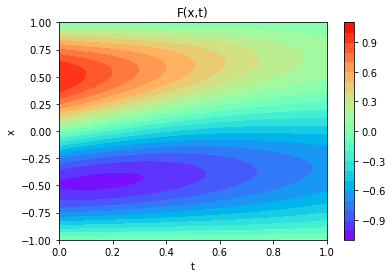

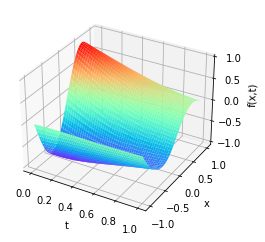

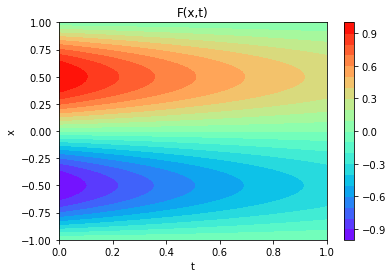

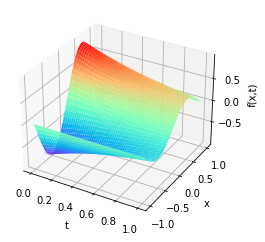

In [16]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)
plot3D_Matrix(X,T,y_real)